# Использую MLflow чтобы сохранять результаты экспериментов.

In [ ]:
# pip install influxdb
# pip install mlflow

!pip install mlflow --quiet
!pip install pyngrok --quiet

import mlflow

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "29nl08Mss0jwzgSAr2oBdk4eSKw_4cHhnEoa8Nmn5yMVnnCFy"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://ba43-34-74-161-240.ngrok.io


# Первичная обработка основных признаков

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree 
from sklearn.linear_model import RidgeClassifier

# Pipline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, 
                                   LabelEncoder, MinMaxScaler)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Metrix
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score
from sklearn.metrics import (roc_curve, auc, roc_auc_score,
                             confusion_matrix, mean_squared_error)

# Other
from urllib.parse import urlparse
import itertools
from sklearn.datasets import load_iris
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot
from xgboost import plot_importance

sns.set(style="darkgrid")

In [ ]:
data = pd.read_csv("data.csv", encoding='latin1')

Цели для обработки данных:

*   Remove features associated with >85% missing values
*   Remove constant features
*   Remove duplicates features
*   Remove duplicate rows
*   Remove highly collinear features

# Вспомагательная функция для построения графиков:



In [ ]:
# https://towardsdatascience.com/financial-data-analysis-bf4b5e78c45c
# Эта функция строит графики с учетом того, категориальный ли признак

def plot_feature(col_name, isContinuous, df): 
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=90)
    
    # Plot without loan status
    if isContinuous:
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)
    plt.xticks(rotation = 90)

# Plot with loan status
    if isContinuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by Loan Status')
    else:
        data = df.groupby(col_name)['loan_status'].value_counts(normalize=True).to_frame('proportion').reset_index()        
        sns.barplot(x = col_name, y = 'proportion', hue= "loan_status", data = data, saturation=1, ax=ax2)
        ax2.set_ylabel('Loan fraction')
        ax2.set_title('Loan status')
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    plt.show()

# Описание данных

1.	loan_amnt – Запрашиваемая у банка сумма для кредита. 
2.	funded_amnt — Общая сумма обязательств по кредиту на данный момент. 
3.	funded_amnt_inv — Общая сумма обязательств инвесторов. 
4.	term — Количество платежей по запрошенной сумме. 
5.	int_rate — Процентная ставка кредита. 
6.	installment — Размер первоначального взноса. 
7.	grade — Оценка кредитного риска. 
8.	emp_title — Должность, представленная заемщиком при получении кредита. 
9.	emp_length — Трудовой опыт в годах. 
10.	 home_ownership — Статус собственности жилья на момент открытия кредита. 
11.	 annual_inc — Годовой доход. 
12.	verification_status — Статус верификации. 
13.	issue_d — Месяц, в который получено финансирование. 
14.	purpose — Цель взятия кредита. 
15.	addr_state — Государство, указанное в заявке на получение кредита. 
16.	dti — Процент ежемесячного валового дохода потребителя, который идет на выплату долгов. 
17.	delinq_2yrs — Количество просроченных платежей более чем на 30 дней за последние два года. 
18.	earliest_cr_line — Месяц открытия самой ранней кредитной истории. 
19.	inq_last_6mths — Количество обращений кредитора в бюро кредитных историй за последние 6 месяцев. 
20.	open_acc — Это количество открытых кредитов в данный момент. 
21.	revol_bal — Общий кредитный оборотный остаток. 
22.	revol_util — Доля утилизации кредита 
23.	total_acc — Общее количество активных и закрытых кредитов. 
24.	out_prncp — Оставшаяся непогашенная сумма. 
25.	total_pymnt — Выплаты, полученные на сегодняшний день. 
26.	loan_status — Текущий статус кредита. 
27.	risk — Дефолт (1) или не дефолт (0).

## Здесь же попробуем создать новые признаки

Добавила один признак: средняя выплата в месяц, без учета процентной ставки

In [ ]:
data['term_month'] = data['term'].str.split().str[0]
data['term_month'] = pd.to_numeric(data['term_month'])

data = data.assign(mean_payment = data['loan_amnt'] / data['term_month'])

data.drop('term_month', axis=1,  inplace=True) 

# Разведочный анализ данных и обработка

Сразу удалим все дубликаты:

In [ ]:
data.drop_duplicates(inplace= True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310704 entries, 0 to 310703
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   310704 non-null  int64  
 1   loan_amnt            310704 non-null  int64  
 2   funded_amnt          310704 non-null  int64  
 3   funded_amnt_inv      310704 non-null  float64
 4   term                 310704 non-null  object 
 5   int_rate             310704 non-null  float64
 6   installment          310704 non-null  float64
 7   grade                310704 non-null  object 
 8   emp_title            281139 non-null  object 
 9   emp_length           288089 non-null  object 
 10  home_ownership       310704 non-null  object 
 11  annual_inc           310704 non-null  float64
 12  verification_status  310704 non-null  object 
 13  issue_d              310704 non-null  object 
 14  purpose              310704 non-null  object 
 15  addr_state       

Посмотрим на пропущенные данные:

In [ ]:
data.isna().sum()

id                         0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
emp_title              29565
emp_length             22615
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
purpose                    0
addr_state                 0
dti                      148
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             1
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util               213
total_acc                  0
out_prncp                  0
total_pymnt                0
loan_status                0
risk                       0
mean_payment               0
dtype: int64

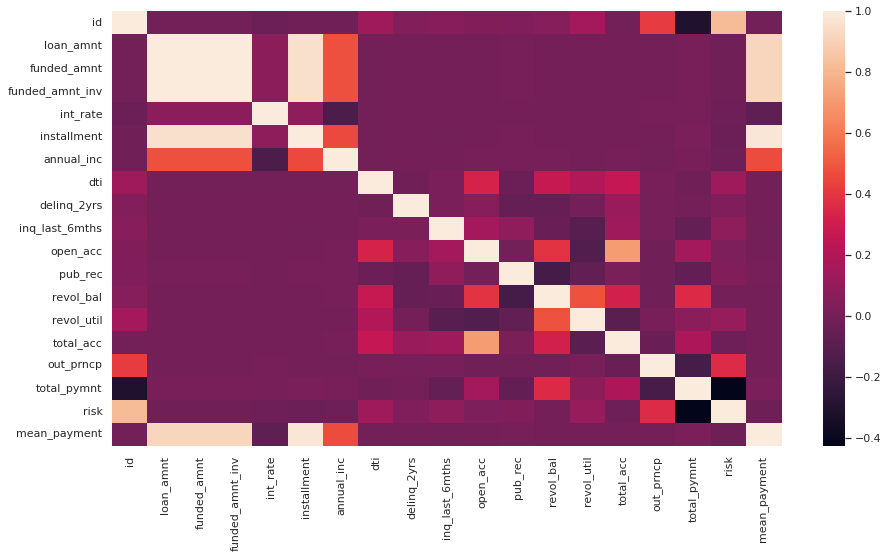

In [ ]:
corr_matrix = data.corr(method = 'spearman')

plt.figure(figsize = (15, 8))
sns.heatmap(corr_matrix.T)

plt.show()

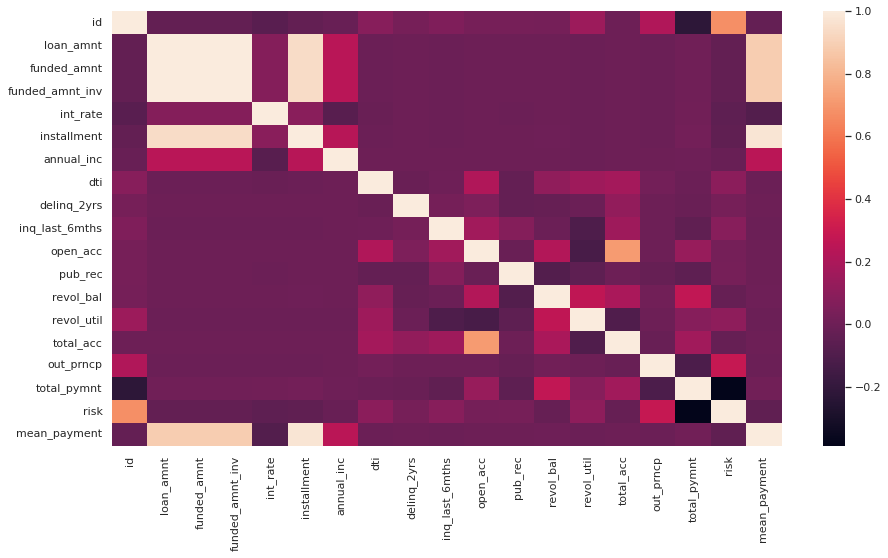

In [ ]:
corr_matrix = data.corr(method = 'pearson')

plt.figure(figsize = (15, 8))
sns.heatmap(corr_matrix.T)

plt.show()

In [ ]:
data.describe()

id      loan_amnt    funded_amnt  funded_amnt_inv  \
count  3.107040e+05  310704.000000  310704.000000    310704.000000   
mean   6.204661e+05   15518.606133   15518.606133     15511.817884   
std    3.928862e+05    9196.532109    9196.532109      9195.219672   
min    1.000000e+00    1000.000000    1000.000000       725.000000   
25%    7.767675e+04    8275.000000    8275.000000      8250.000000   
50%    7.586255e+05   14000.000000   14000.000000     14000.000000   
75%    9.708992e+05   20800.000000   20800.000000     20800.000000   
max    1.048575e+06   40000.000000   40000.000000     40000.000000   

            int_rate    installment    annual_inc            dti  \
count  310704.000000  310704.000000  3.107040e+05  310556.000000   
mean       12.565801     452.838937  8.053998e+04      19.020776   
std         4.702061     264.514016  9.286294e+04      12.339552   
min         5.320000      14.770000  0.000000e+00      -1.000000   
25%         8.810000     259.420000  4.800000e+04      12.070000   
50%        11.990000     387.550000  6.720000e+04      18.190000   
75%        15.310000     602.950000  9.500000e+04      25.080000   
max        30.990000    1618.240000  9.757200e+06     999.000000   

         delinq_2yrs  inq_last_6mths       open_acc        pub_rec  \
count  310704.000000   310703.000000  310704.000000  310704.000000   
mean        0.338029        0.607374      11.882889       0.248008   
std         0.921206        0.888372       5.793843       0.671583   
min         0.000000        0.000000       0.000000       0.000000   
25%         0.000000        0.000000       8.000000       0.000000   
50%         0.000000        0.000000      11.000000       0.000000   
75%         0.000000        1.000000      15.000000       0.000000   
max        21.000000        5.000000      81.000000      86.000000   

          revol_bal     revol_util      total_acc      out_prncp  \
count  3.107040e+05  310491.000000  310704.000000  310704.000000   
mean   1.605273e+04      48.495109      24.916757     723.861865   
std    2.322824e+04      24.812508      12.312579    3602.732652   
min    0.000000e+00       0.000000       2.000000       0.000000   
25%    5.515750e+03      29.600000      16.000000       0.000000   
50%    1.059000e+04      48.000000      23.000000       0.000000   
75%    1.908500e+04      67.300000      32.000000       0.000000   
max    1.044210e+06     182.800000     176.000000   40000.000000   

         total_pymnt           risk   mean_payment  
count  310704.000000  310704.000000  310704.000000  
mean    13430.483430       0.333655     360.293718  
std     10010.944733       0.471519     214.542515  
min         0.000000       0.000000      27.777778  
25%      5783.218540       0.000000     200.000000  
50%     10741.860000       0.000000     305.555556  
75%     18592.573820       1.000000     466.666667  
max     59808.262090       1.000000    1111.111111

### Посмотрим на всякие диаграмы рассеяния (многомерный анализ)

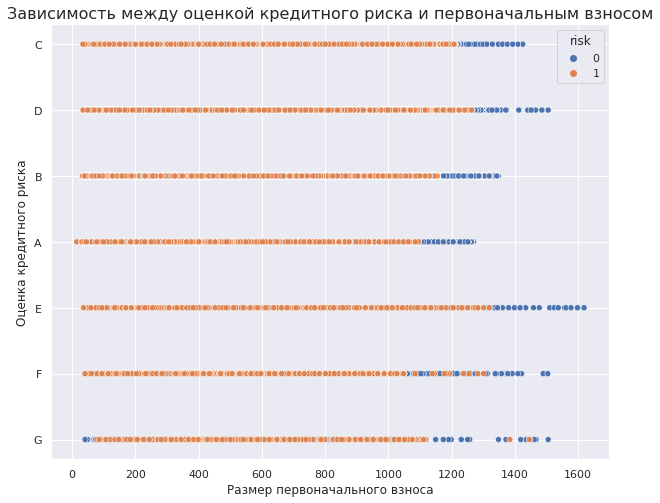

In [ ]:
from IPython.core.pylabtools import figsize

sns.set_style('darkgrid')
plt.figure(figsize=(10, 8))

markers = {"0": "s", "1": "X"}
plt.title('Зависимость между оценкой кредитного риска и первоначальным взносом', size=16)
plt.xlabel('Размер первоначального взноса', size=12)
plt.ylabel('Оценка кредитного риска', size=12)
sns.scatterplot(x='installment', y='grade', data=data, hue='risk', markers=markers, palette='deep')
plt.show()

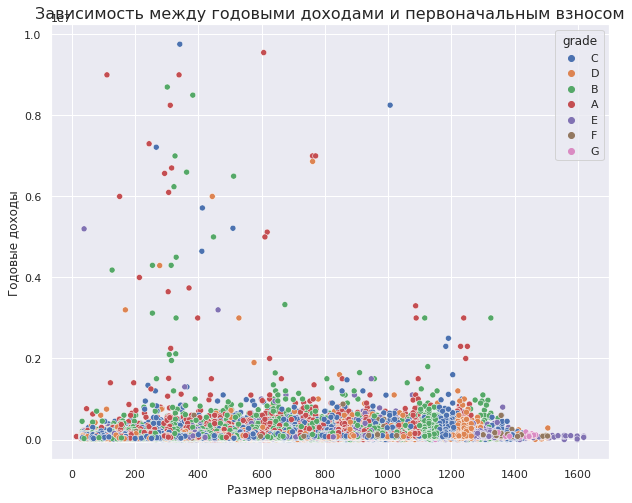

In [ ]:
sns.set_style('darkgrid')

plt.figure(figsize=(10, 8))

plt.title('Зависимость между годовыми доходами и первоначальным взносом', size=16)
plt.xlabel('Размер первоначального взноса', size=12)
plt.ylabel('Годовые доходы', size=12)

sns.scatterplot(x='installment', y='annual_inc', data=data, hue='grade', palette='deep')
plt.show()

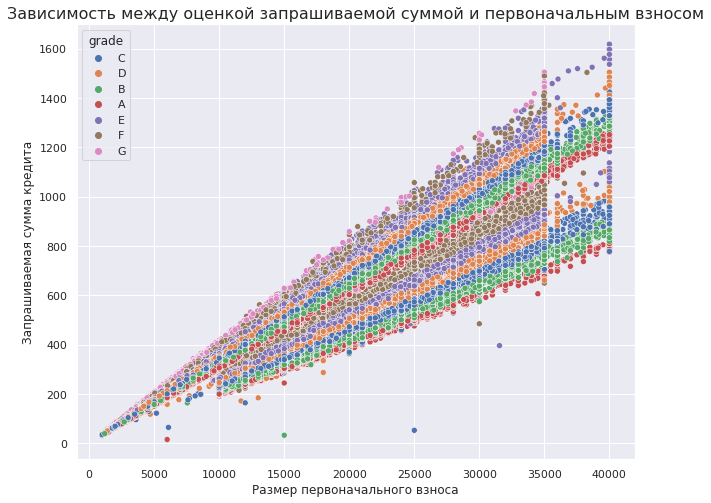

In [ ]:
sns.set_style('darkgrid')

plt.figure(figsize=(10, 8))

plt.title('Зависимость между оценкой запрашиваемой суммой и первоначальным взносом', size=16)
plt.xlabel('Размер первоначального взноса', size=12)
plt.ylabel('Запрашиваемая сумма кредита', size=12)

sns.scatterplot(x='loan_amnt', y='installment', data=data, hue='grade', palette='deep')
plt.show()

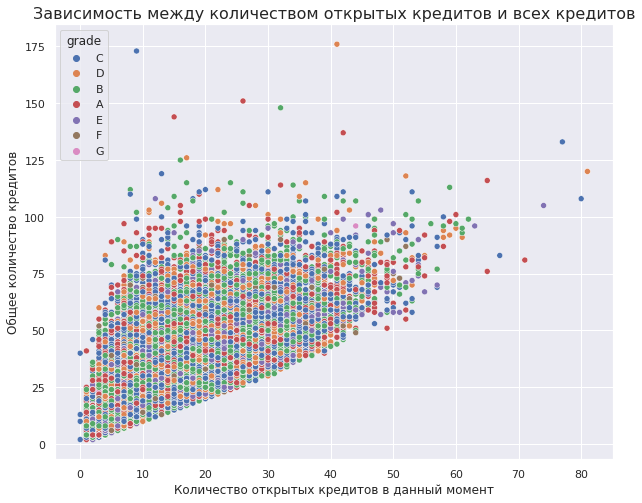

In [ ]:
sns.set_style('darkgrid')

plt.figure(figsize=(10, 8))

plt.title('Зависимость между количеством открытых кредитов и всех кредитов', size=16)
plt.xlabel('Количество открытых кредитов в данный момент', size=12)
plt.ylabel('Общее количество кредитов', size=12)

sns.scatterplot(x='open_acc', y='total_acc', data=data, hue='grade', palette='deep')
plt.show()

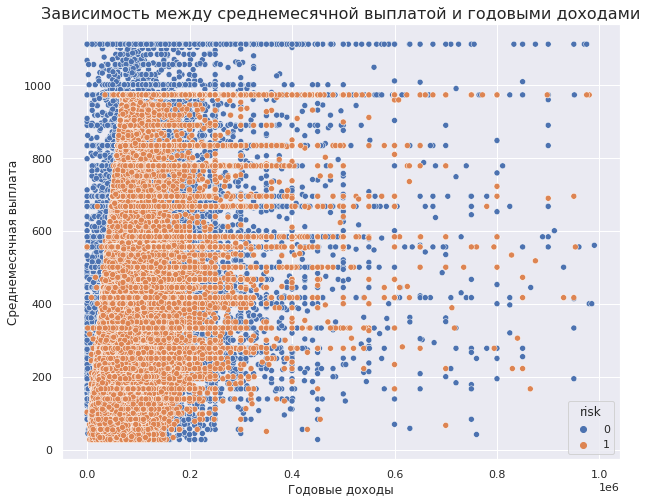

In [ ]:
sns.set_style('darkgrid')

plt.figure(figsize=(10, 8))

plt.title('Зависимость между среднемесячной выплатой и годовыми доходами', size=16)
plt.xlabel('Годовые доходы', size=12)
plt.ylabel('Среднемесячная выплата', size=12)

sns.scatterplot(x=data[data['annual_inc'] < 1000000]['annual_inc'], y='mean_payment', data=data, hue='risk', palette='deep')
plt.show()

### Далее пройду по всем признакам и рассмотрю их детально.

### risk

In [ ]:
data['risk'].value_counts()

0    207036
1    103668
Name: risk, dtype: int64

Важно было убедиться, что у нас достаточное количество дефолтов для исследования и разница между признаками не превышает 90%.

### loan_amnt

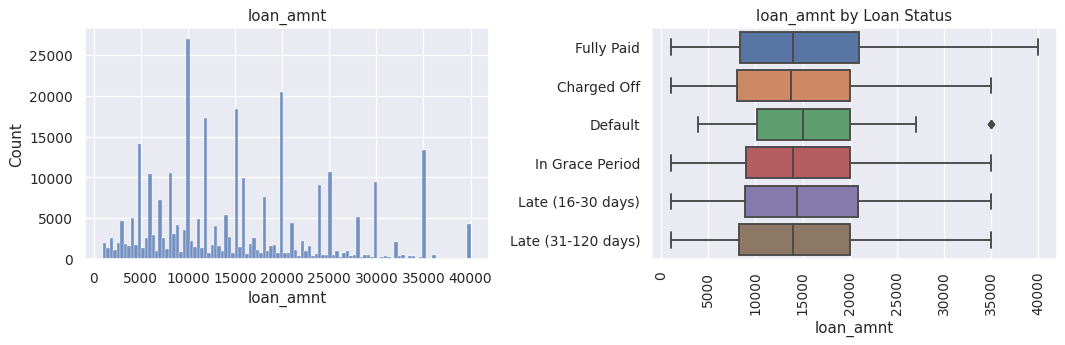

In [ ]:
plot_feature('loan_amnt', True, data)

Сложно тут оценивать выбросы, потому что в принципе сумма займа не должна сильно зависеть от вероятности дефолта, поэтому пока оставлю так. Возможно, в будущем для рассмотрения стоит оставить только Fully Paid и Charged Off.

In [ ]:
data = data.loc[(data['loan_status'].isin(['Fully Paid', 'Charged Off']))]

### annual_inc

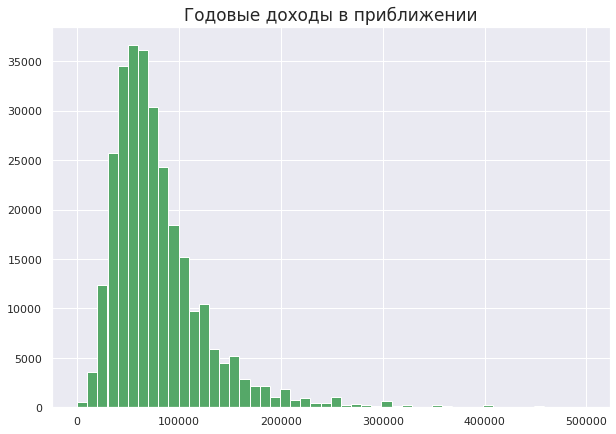

In [ ]:
data[data['annual_inc'] < 500000]['annual_inc'].hist(bins=50, figsize=(10, 7), color='g')

plt.title('Годовые доходы в приближении', size = 17)
plt.show()

### int_rate

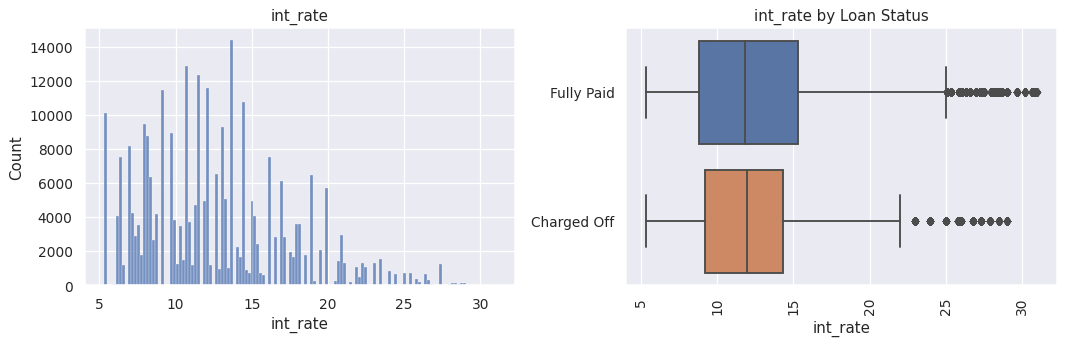

In [ ]:
plot_feature('int_rate', True, data)

### installment

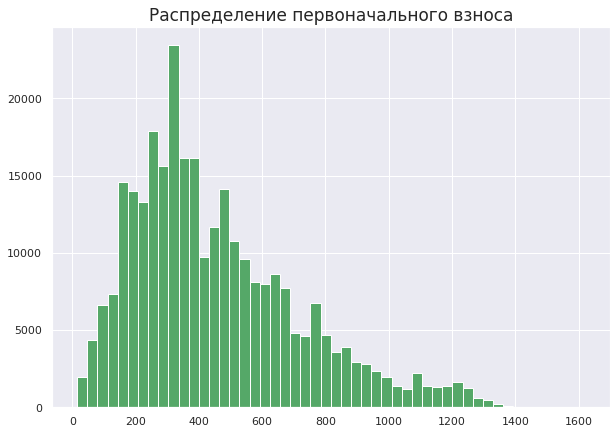

In [ ]:
data['installment'].hist(color = 'g', bins=50, figsize=(10, 7))

plt.title('Распределение первоначального взноса', size = 17)
plt.show()

### funded_amnt и funded_amnt_inv

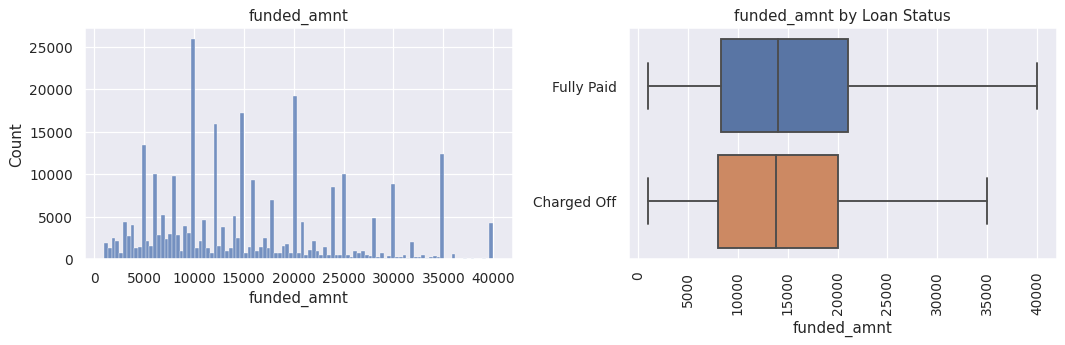

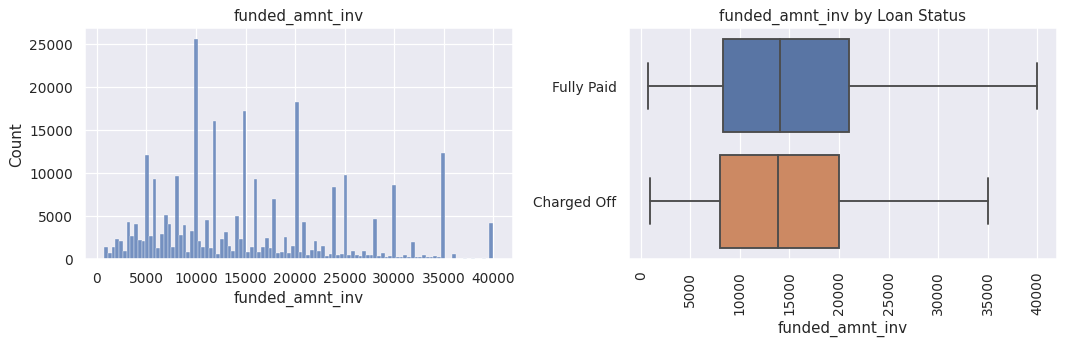

In [ ]:
plot_feature('funded_amnt', True, data)
plot_feature('funded_amnt_inv', True, data)

Не уверена, нужны ли нам два настолько близких признака. Я бы оставила только funded_amnt, потому что по ощущениям данные там чуть более полные.

In [ ]:
data.drop('funded_amnt_inv', axis=1,  inplace=True) 

### pub_rec

In [ ]:
data.drop('pub_rec', axis=1, inplace=True) 
# не поняли что это за признак

### emp_title

In [ ]:
data['emp_title'].value_counts()

Teacher                         5309
Manager                         4609
Owner                           2539
Registered Nurse                2261
Driver                          2032
                                ... 
Lineman/Troubleman                 1
Senior SEC Reporting Analyst       1
surgery scheduler                  1
PBX Operator,V.A.                  1
Economist                          1
Name: emp_title, Length: 86769, dtype: int64

Слишком много уникальных профессий и вероятнее всего они не отражают ничего дельного, поэтому этот признак можно удалить.

In [ ]:
data.drop('emp_title', axis=1, inplace=True) 

### home_ownership

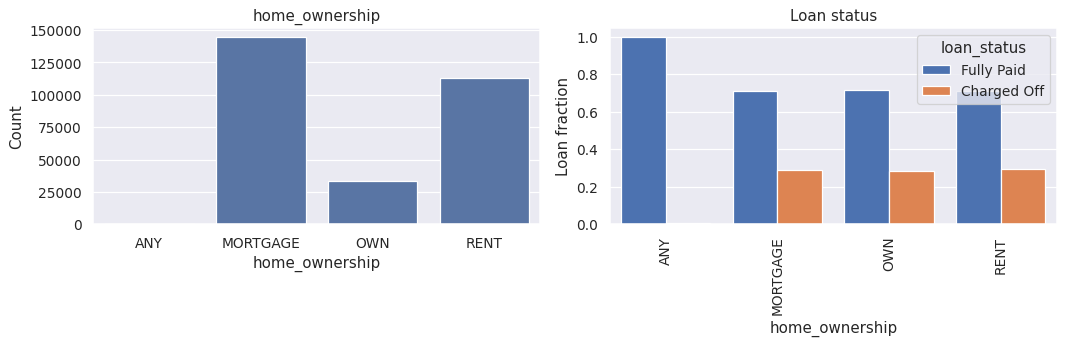

In [ ]:
plot_feature('home_ownership', False, data)

Возможно на категориальных данных, которых сравнительно меньше остальных, модель будет сильно переобучаться, поэтому я думаю удалю "ANY"

In [ ]:
data = data.loc[data['home_ownership'] != "ANY"]
#  data = data.drop(np.where(data['home_ownership'] == "ANY")[0])

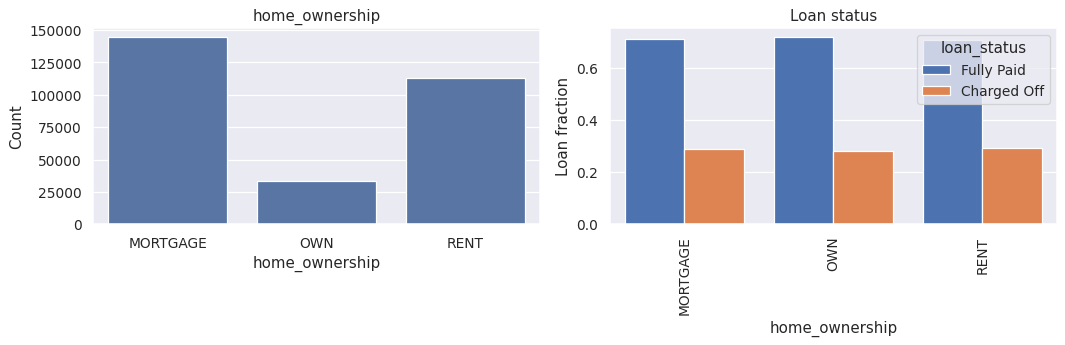

In [ ]:
plot_feature('home_ownership', False, data)

### emp_length

Так как меньше 10% признаков в emp_title и  emp_lenght пропущены, не будем выкидывать эти признаки, а просто заменим значения пустой строкой.

In [ ]:
data.fillna(value={'emp_title': ''}, inplace = True)

Ниже с **emp_length** надо подумать, может лучше сделать просто количество лет и не делать это категориальным признаком

In [ ]:
data['emp_length'].unique()

array(['10+ years', '6 years', '4 years', '< 1 year', '2 years',
       '9 years', nan, '5 years', '3 years', '7 years', '1 year',
       '8 years'], dtype=object)

In [ ]:
data.fillna(value={'emp_length': 'No'}, inplace = True)

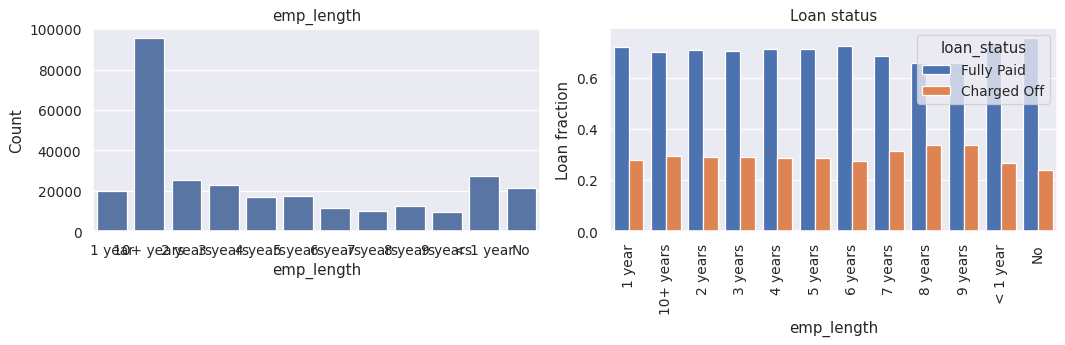

In [ ]:
plot_feature('emp_length', False, data)

### **dti**

Мне кажется один из важнейших признаков который должен очень сильно коррелировать - это процент с дохода, который идет на выплату. Очень красивое распределение

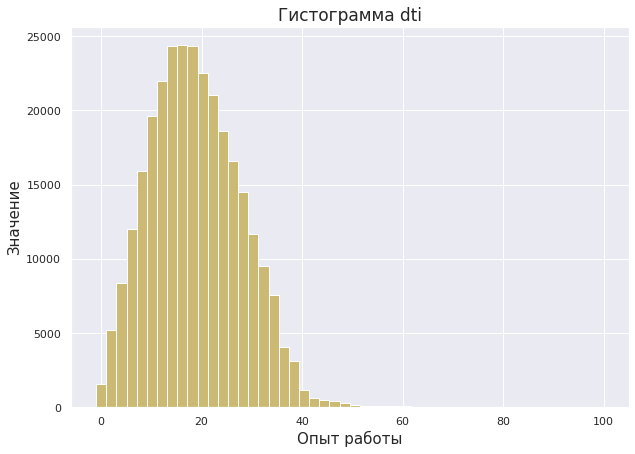

In [ ]:
plt.ticklabel_format(style='plain')
# plt.plot(data['dti'], )
# data['dti'].hist(bins=50, facecolor='g', figsize=(10, 7))
data[data['dti'] < 100]['dti'].hist(bins=50, color='y', figsize=(10, 7))

plt.title('Гистограмма dti', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

In [ ]:
data.fillna(value={'dti': 0, 'revol_util': 0}, inplace = True)

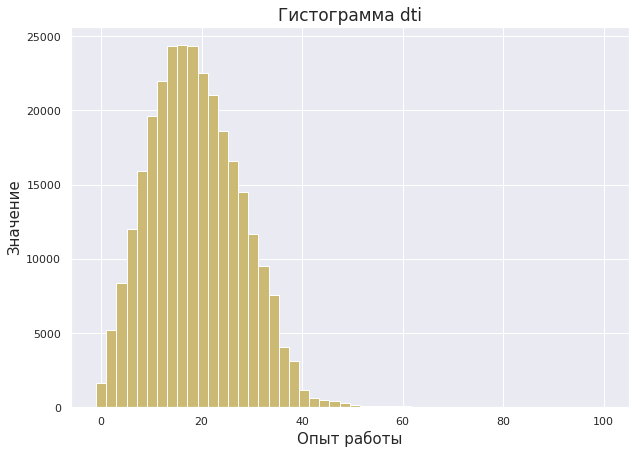

In [ ]:
plt.ticklabel_format(style='plain')
# plt.plot(data['dti'], )
# data['dti'].hist(bins=50, facecolor='g', figsize=(10, 7))
data[data['dti'] < 100]['dti'].hist(bins=50, color='y', figsize=(10, 7))

plt.title('Гистограмма dti', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

Заполнение нулями ничего сильно не повредило, поэтому супер.

### **grade**

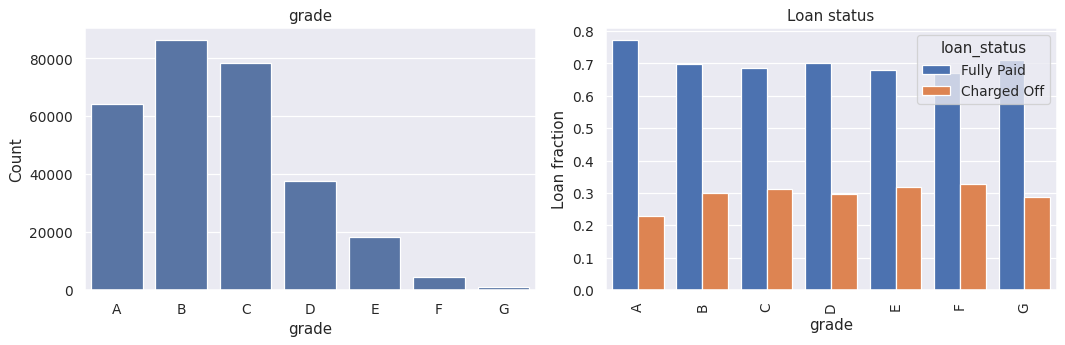

In [ ]:
plot_feature('grade', False, data)

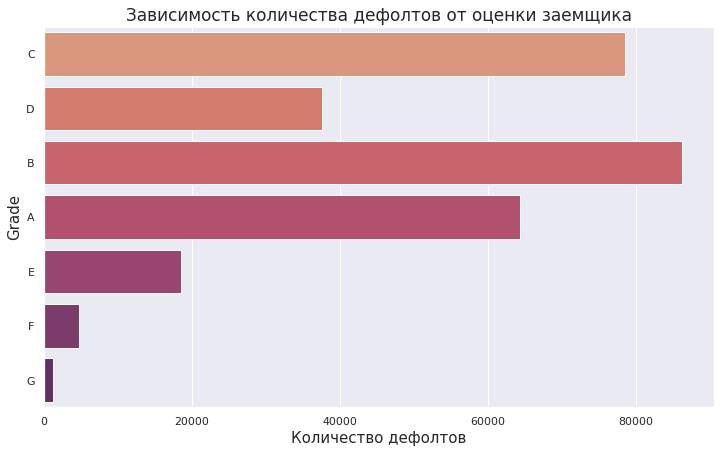

In [ ]:
plt.figure(figsize=(12, 7))
sns.countplot(data = data, y = data['grade'], palette="flare")

plt.title('Зависимость количества дефолтов от оценки заемщика', size = 17)
plt.xlabel('Количество дефолтов', size = 15)
plt.ylabel('Grade', size = 15)
plt.show()

### **issue_d** и **earliest_cr_line**

Два признака с датами, которые возможно стоит перевести в data type, либо я вычитала что можно оставить тольк месяц, из-за того что мы работаем с данными всего за пару лет. (И перевести в категориальные признаки)

In [ ]:
data['issue_d'].unique()

array(['Dec-18', 'Nov-18', 'Oct-18', 'Mar-16', 'Feb-16', 'Jan-16',
       'Nov-15', 'Dec-15', 'Oct-15'], dtype=object)

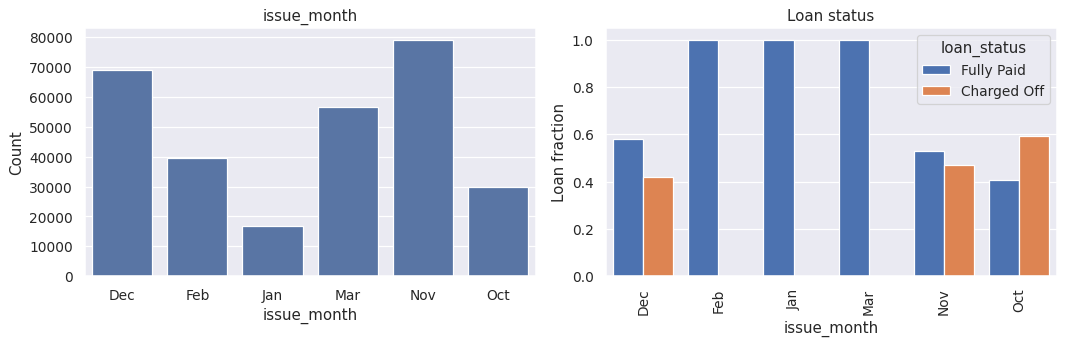

In [ ]:
data['issue_month'] = pd.Series(data.issue_d).str.replace(r'-\d+', '')

data.drop('issue_d', axis=1, inplace=True) 
plot_feature('issue_month', False, data)

In [ ]:
# data[data['issue_d'] == 'Dec-18']['risk'].value_counts()

In [ ]:
# data[data['issue_d'] == 'Dec-15']['risk'].value_counts()

Пока непонятно, как это может помочь, не буду строить график из-за слишком многого количества признаков, но возможно они сойдут за хорошие категориальные.

In [ ]:
data['earliest_cr_line']

0         Jan-12
1         Jun-09
2         Feb-99
3         Dec-03
4         Oct-97
           ...  
310352    Nov-97
310353    Sep-05
310354    Aug-02
310355    Nov-92
310356    Aug-06
Name: earliest_cr_line, Length: 290961, dtype: object

In [ ]:
data['earliest_cr_year'] = data.earliest_cr_line.str.replace(r'\w+-', '').astype(np.int)

### **loan_status**

In [ ]:
data['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

### **purpose**

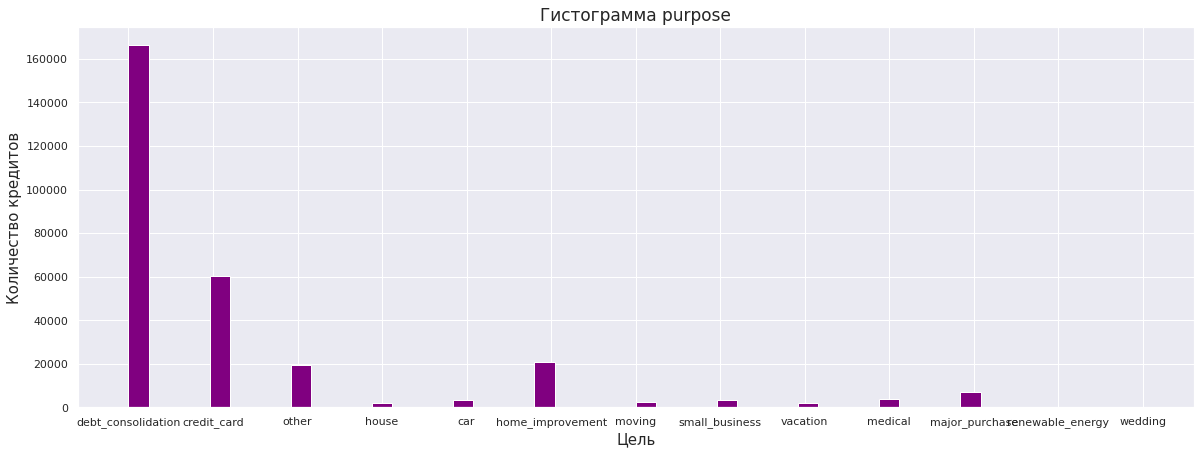

In [ ]:
plt.ticklabel_format(style='plain')
data['purpose'].hist(bins=50, color='purple', figsize=(20, 7))

plt.title('Гистограмма purpose', size = 17)
plt.xlabel('Цель', size = 15)
plt.ylabel('Количество кредитов', size = 15)
plt.show()

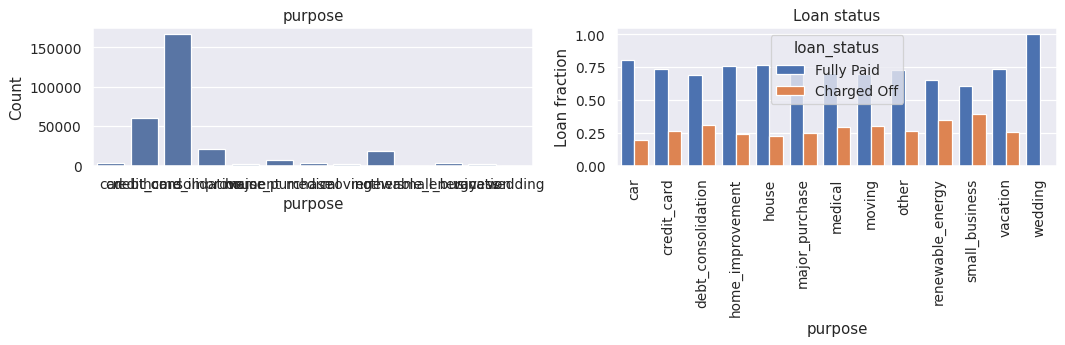

In [ ]:
plot_feature('purpose', False, data)

In [ ]:
data['purpose'].value_counts()

debt_consolidation    166400
credit_card            60272
home_improvement       20907
other                  19426
major_purchase          7128
medical                 3777
car                     3252
small_business          3182
moving                  2276
vacation                2161
house                   1975
renewable_energy         203
wedding                    2
Name: purpose, dtype: int64

### **verification_status**

In [ ]:
data['verification_status']

0            Not Verified
1         Source Verified
2         Source Verified
3         Source Verified
4            Not Verified
               ...       
310352           Verified
310353       Not Verified
310354    Source Verified
310355           Verified
310356    Source Verified
Name: verification_status, Length: 290961, dtype: object

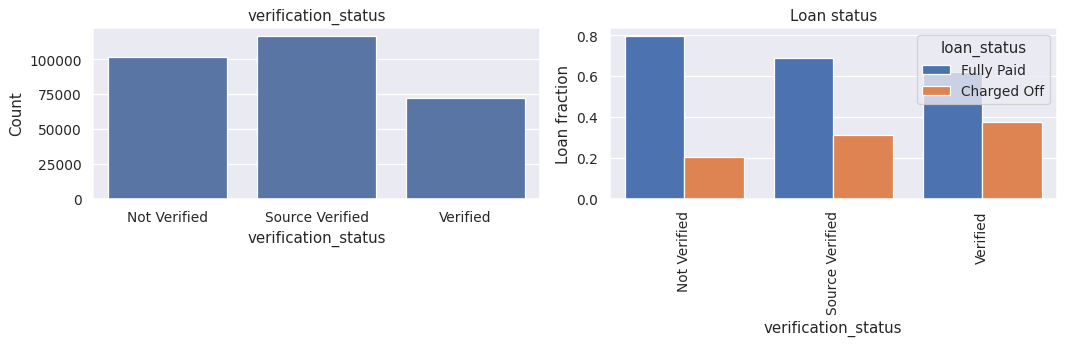

In [ ]:
plot_feature('verification_status', False, data)

Очень странно, что у неверефицированных намного больший процент успешных выплат, хотя ожидается наоборот.

### **term**

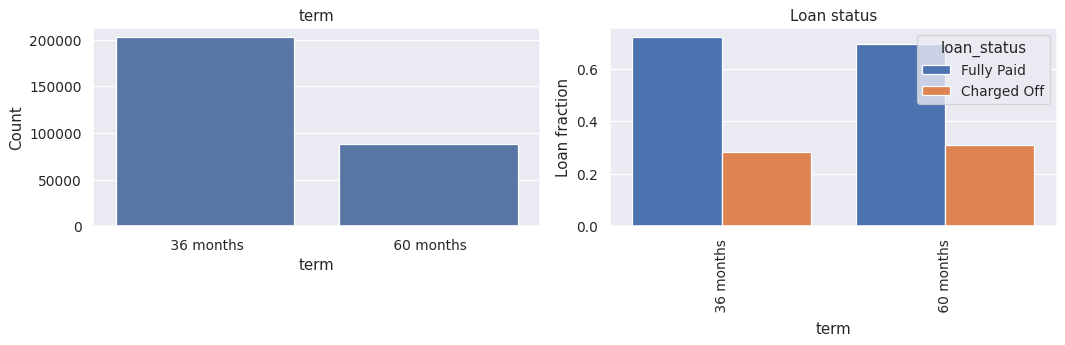

In [ ]:
plot_feature('term', False, data)

### **addr_state**

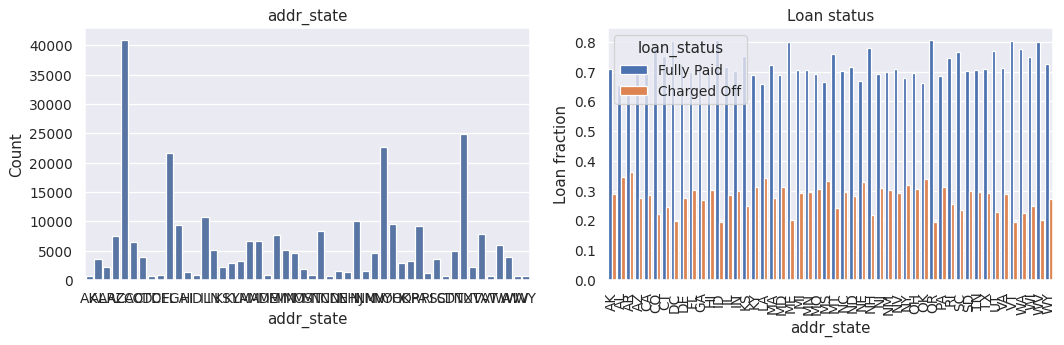

In [ ]:
plot_feature('addr_state', False, data)

### **delinq_2yrs** and **inq_last_6mths**

In [ ]:
data.drop('delinq_2yrs', axis=1, inplace=True) 

In [ ]:
data.drop('inq_last_6mths', axis=1, inplace=True) 

### **open_acc**

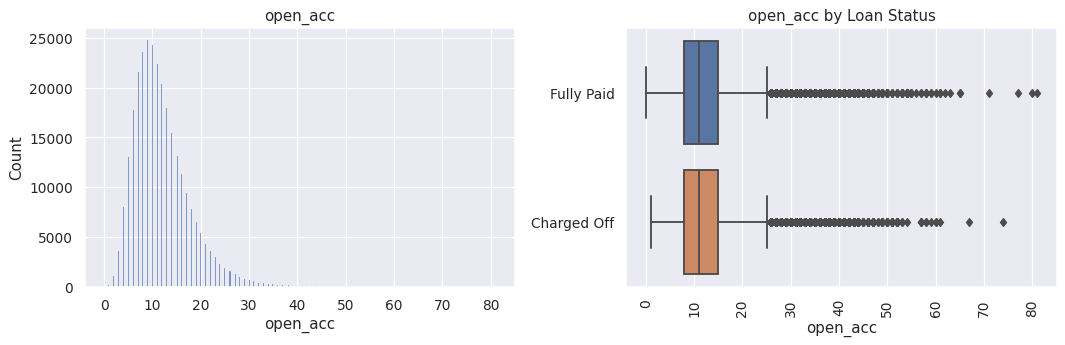

In [ ]:
plot_feature('open_acc', True, data)

### **revol_util**

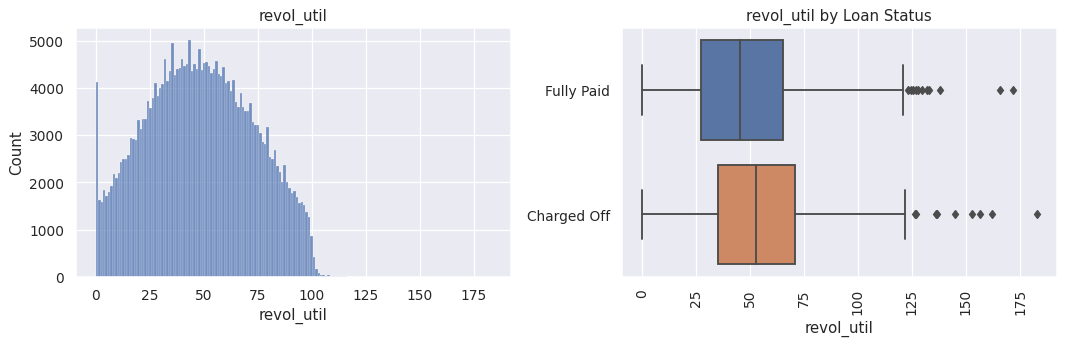

In [ ]:
plot_feature('revol_util', True, data)

### **total_acc**

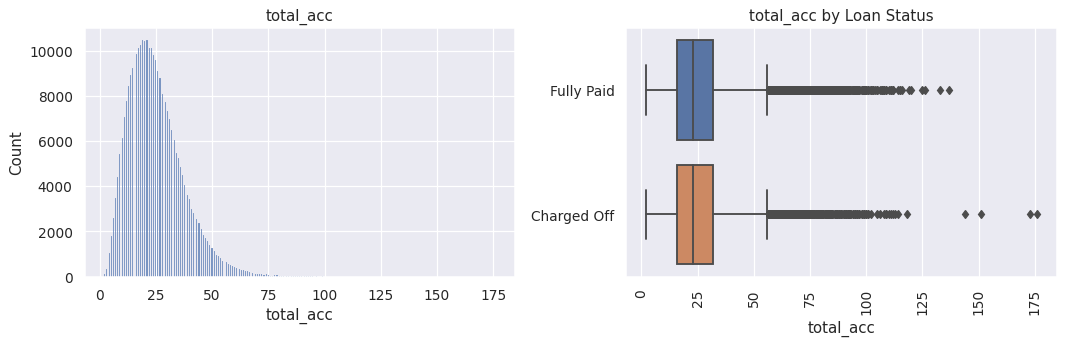

In [ ]:
plot_feature('total_acc', True, data)

### **out_prncp**

In [ ]:
data['out_prncp']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
310352    0.0
310353    0.0
310354    0.0
310355    0.0
310356    0.0
Name: out_prncp, Length: 290961, dtype: float64

Долго не могла понять что произошло, но оказалось что когда я оставила только два типа статусов: выплачено и нет, то все данные в которых был еще какой-то остаток удалились. Пока что я не планирую оставлять больше двух статусов, поэтому этот признак можно полностью удалить.

In [ ]:
data.drop('out_prncp', axis=1, inplace=True) 

### **total_pymnt**

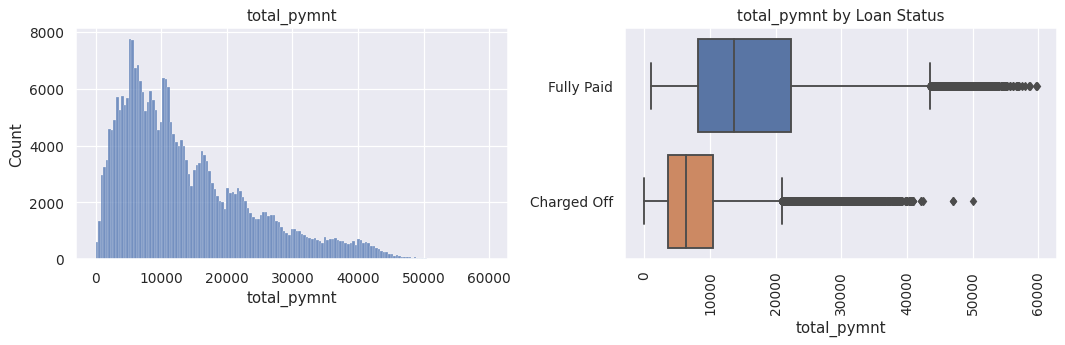

In [ ]:
plot_feature('total_pymnt', True, data)

In [ ]:
data.drop('total_pymnt', axis=1, inplace=True) 

### **ID**

In [ ]:
data.drop('id', axis=1, inplace=True) 

## Итог обработки всех признаков:

Финально посмотрим на матрицу корреляции после обработки всех признаков:

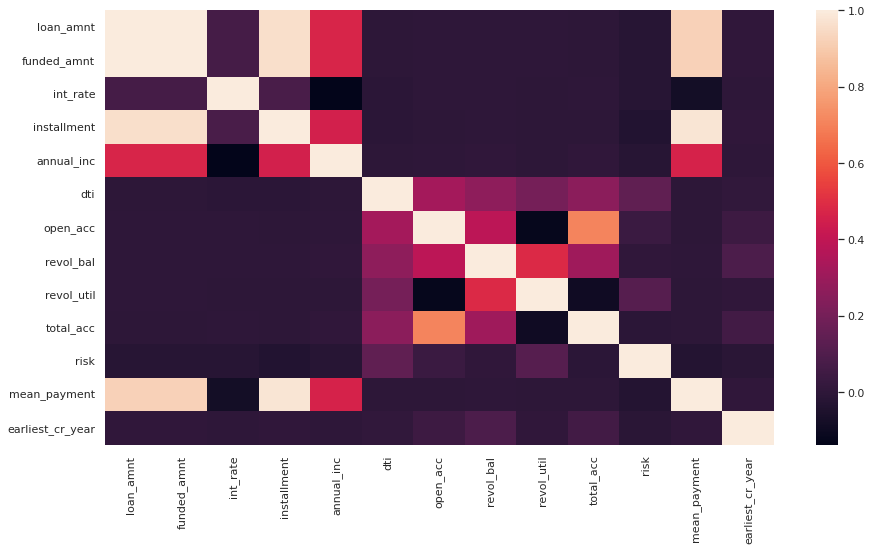

In [ ]:
corr_matrix = data.corr(method = 'spearman')

plt.figure(figsize = (15, 8), )
sns.heatmap(corr_matrix.T)

plt.show()

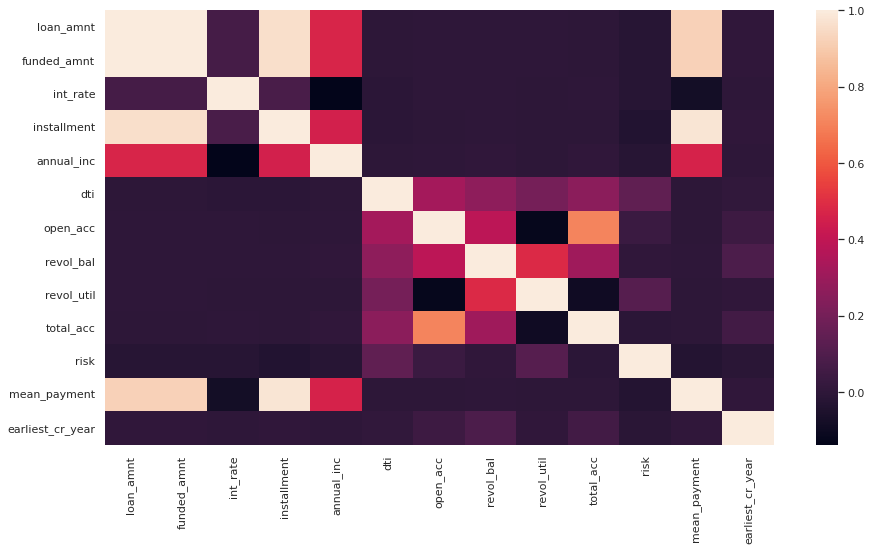

In [ ]:
# Without delinq_2yrs

corr_matrix = data.corr(method = 'spearman')

plt.figure(figsize = (15, 8), )
sns.heatmap(corr_matrix.T)

plt.show()

## Хи-квадрат

In [ ]:
data.head()

loan_amnt  funded_amnt        term  int_rate  installment grade emp_length  \
0       2500         2500   36 months     13.56        84.92     C  10+ years   
1      30000        30000   60 months     18.94       777.23     D  10+ years   
2       5000         5000   36 months     17.97       180.69     D    6 years   
3       4000         4000   36 months     18.94       146.51     D  10+ years   
4      30000        30000   60 months     16.14       731.78     C  10+ years   

  home_ownership  annual_inc verification_status  ... earliest_cr_line  \
0           RENT     55000.0        Not Verified  ...           Jan-12   
1       MORTGAGE     90000.0     Source Verified  ...           Jun-09   
2       MORTGAGE     59280.0     Source Verified  ...           Feb-99   
3       MORTGAGE     92000.0     Source Verified  ...           Dec-03   
4       MORTGAGE     57250.0        Not Verified  ...           Oct-97   

  open_acc  revol_bal revol_util  total_acc  loan_status  risk  mean_payment  \
0       11      15603       37.0         19   Fully Paid     0     69.444444   
1       18      34971       64.5         37   Fully Paid     0    500.000000   
2        9      25416       29.9         19   Fully Paid     0    138.888889   
3       12       4472       15.3         25   Fully Paid     0    111.111111   
4       21      36812       65.7         37   Fully Paid     0    500.000000   

  issue_month  earliest_cr_year  
0         Dec                12  
1         Dec                 9  
2         Dec                99  
3         Dec                 3  
4         Dec                97  

[5 rows x 23 columns]

In [ ]:
from scipy.stats import chi2, chi2_contingency
import matplotlib.pyplot as plt

In [ ]:
chisqt = pd.crosstab(data.grade[130000:], data.risk, margins=True)
print(chisqt)

risk       0      1     All
grade                      
A      14128  14711   28839
B      24232  25916   50148
C      21243  24601   45844
D       9158  11192   20350
E       5425   5901   11326
F       2094   1532    3626
G        502    326     828
All    76782  84179  160961


In [ ]:
value = np.array([chisqt[0][0:4].values,
                  chisqt[1][0:4].values])

value

array([[14128, 24232, 21243,  9158],
       [14711, 25916, 24601, 11192]])

In [ ]:
answer = chi2_contingency(value)
print("Статистическое значение: ", answer[0])
print("P - значение: ", answer[1])
print("Степень свободы: ", answer[2])

Статистическое значение:  113.87129134094806
P - значение:  1.6109250665243946e-24
Степень свободы:  3


# Расчет IV и преобразование WOE


In [ ]:
# Преобразование WOE

def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()

    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [ ]:
data_for_test = data.copy()

In [ ]:
numeric_features = data_for_test.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical = data_for_test.select_dtypes(include=['object']).columns.tolist()

In [ ]:
# Делим интервальные переменные на бины

for feature in numeric_features:
    data_for_test[feature + '_bin'] = pd.qcut(data_for_test[feature], 10, duplicates='drop')
    data_for_test[feature + '_bin'] = data_for_test[feature + '_bin'].cat.add_categories("0-0").fillna("0-0")

for feature in categorical:
    data_for_test[feature] = data_for_test[feature].fillna("0-0") 

In [ ]:
numeric_features.remove('risk')

In [ ]:
categorical.remove('loan_status')
categorical.remove('emp_title')

In [ ]:
# Разделим на трейн и тест выборку 

train, test = train_test_split(data_for_test, test_size=0.3, random_state=40, stratify=data['risk'])

In [ ]:
train['risk'].describe()

count    217492.000000
mean          0.333654
std           0.471519
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: risk, dtype: float64

In [ ]:
test['risk'].describe()

count    93212.000000
mean         0.333659
std          0.471522
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: risk, dtype: float64

In [ ]:
scorecard = pd.DataFrame()
save_iv_num = pd.DataFrame(columns=['num_feature', 'IV'])
save_iv_categ = pd.DataFrame(columns=['categ_feature', 'IV'])

In [ ]:
print('Значения Information value для численных признаков:')


for feature in numeric_features:
    
    df, iv = calculate_woe_iv(train, feature + '_bin', 'risk')
    save_iv_num.loc[len(save_iv_num)] = [feature, iv]
    df['feature'] = feature

    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value' )
    train = train.rename(columns={'WoE':'WoE'+ '_' + feature})
    
    train = train.drop(columns = [feature, feature + '_bin', 'Value'])
    
    test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value' )
    test = test.rename(columns={'WoE':'WoE' + '_' + feature})

    test = test.drop(columns = [feature, feature + '_bin', 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])
    scorecard = scorecard.append(df[['feature', 'Value', 'WoE']])
    
    
    
    print(feature, ':', iv)

Значения Information value для численных признаков:
id : 4.017803783098712e-05
loan_amnt : 0.01661843996710595
funded_amnt : 0.01661843996710595
funded_amnt_inv : 0.0166910890051168
int_rate : 0.16466286990267093
installment : 0.013512357348559823
annual_inc : 0.00432284853734964
dti : 0.07537894871325586
delinq_2yrs : 0.003555303093781853
inq_last_6mths : 0.02235254959589549
open_acc : 0.003810380110261485
pub_rec : 0.0022648254255113374
revol_bal : 0.005523502926866028
revol_util : 0.058861454114121366
total_acc : 0.0031731593573730253
out_prncp : 0.0
total_pymnt : 1.0332042411384381
mean_payment : 0.01379213012566781


In [ ]:
save_iv_num

num_feature        IV
0                id  0.000040
1         loan_amnt  0.016618
2       funded_amnt  0.016618
3   funded_amnt_inv  0.016691
4          int_rate  0.164663
5       installment  0.013512
6        annual_inc  0.004323
7               dti  0.075379
8       delinq_2yrs  0.003555
9    inq_last_6mths  0.022353
10         open_acc  0.003810
11          pub_rec  0.002265
12        revol_bal  0.005524
13       revol_util  0.058861
14        total_acc  0.003173
15        out_prncp  0.000000
16      total_pymnt  1.033204
17     mean_payment  0.013792

In [ ]:
print('Значения Information value для категориальных признаков:')

for feature in categorical:
    df, iv = calculate_woe_iv(train, feature , 'risk')
    df['feature'] = feature
    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
    train = train.rename(columns={'WoE':'WoE'+'_'+feature})
    train = train.drop(columns = [feature, 'Value'])
    
    test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
    test = test.rename(columns={'WoE':'WoE'+'_'+feature})
    test = test.drop(columns = [feature, 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])
    save_iv_categ.loc[len(save_iv_categ)] = [feature, iv]

   
    print(feature, ':', iv)

Значения Information value для категориальных признаков:
term : 0.003189990119970106
grade : 0.02797848028921789
emp_length : 0.012105711711295581
home_ownership : 0.00018240362523494686
verification_status : 0.11140654063138015
issue_d : 0.0
purpose : 0.016797475914860475
addr_state : 0.021222853501956553
earliest_cr_line : 0.019759505811896182


In [ ]:
save_iv_categ

categ_feature        IV
0                 term  0.003190
1                grade  0.027978
2           emp_length  0.012106
3       home_ownership  0.000182
4  verification_status  0.111407
5              issue_d  0.000000
6              purpose  0.016797
7           addr_state  0.021223
8     earliest_cr_line  0.019760

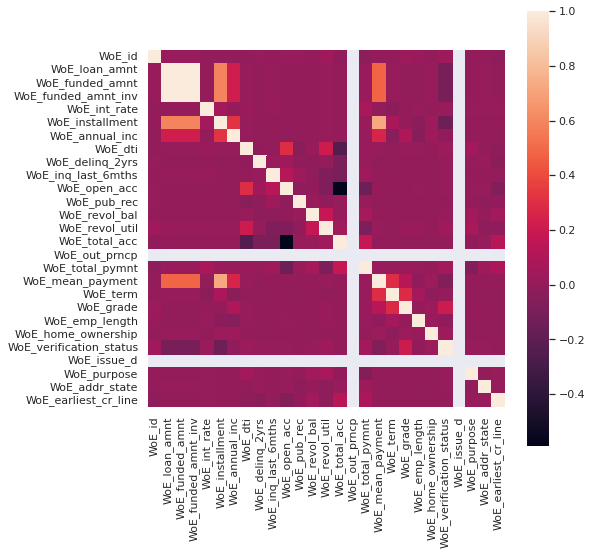

In [ ]:
plt.figure(figsize=(8, 8))
correlations_woe = train.select_dtypes(include=['float64']).corr()

sns.heatmap(correlations_woe, square=True)

plt.show()

# Логистическая регрессия

### На WOE переменных

In [ ]:
from sklearn.metrics import roc_auc_score

def Gini(y_true, y_pred):
  return (2*roc_auc_score(y_true.values, y_pred) - 1)

In [ ]:
data.head()

id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0   1       2500         2500           2500.0   36 months     13.56   
1   2      30000        30000          30000.0   60 months     18.94   
2   3       5000         5000           5000.0   36 months     17.97   
3   4       4000         4000           4000.0   36 months     18.94   
4   5      30000        30000          30000.0   60 months     16.14   

   installment grade       emp_title emp_length  ... open_acc  pub_rec  \
0        84.92     C            Chef  10+ years  ...       11        1   
1       777.23     D     Postmaster   10+ years  ...       18        0   
2       180.69     D  Administrative    6 years  ...        9        0   
3       146.51     D   IT Supervisor  10+ years  ...       12        0   
4       731.78     C        Mechanic  10+ years  ...       21        0   

  revol_bal revol_util total_acc out_prncp   total_pymnt  loan_status risk  \
0     15603       37.0        19       0.0  30026.442500   Fully Paid    0   
1     34971       64.5        37       0.0  40856.678960   Fully Paid    0   
2     25416       29.9        19       0.0  20215.792430   Fully Paid    0   
3      4472       15.3        25       0.0   4549.217149   Fully Paid    0   
4     36812       65.7        37       0.0   8735.148975   Fully Paid    0   

   mean_payment  
0     69.444444  
1    500.000000  
2    138.888889  
3    111.111111  
4    500.000000  

[5 rows x 30 columns]

In [ ]:
features = test.columns.tolist()

In [ ]:
features

['emp_title',
 'loan_status',
 'risk',
 'risk_bin',
 'WoE_id',
 'WoE_loan_amnt',
 'WoE_funded_amnt',
 'WoE_funded_amnt_inv',
 'WoE_int_rate',
 'WoE_installment',
 'WoE_annual_inc',
 'WoE_dti',
 'WoE_delinq_2yrs',
 'WoE_inq_last_6mths',
 'WoE_open_acc',
 'WoE_pub_rec',
 'WoE_revol_bal',
 'WoE_revol_util',
 'WoE_total_acc',
 'WoE_out_prncp',
 'WoE_total_pymnt',
 'WoE_mean_payment',
 'WoE_term',
 'WoE_grade',
 'WoE_emp_length',
 'WoE_home_ownership',
 'WoE_verification_status',
 'WoE_issue_d',
 'WoE_purpose',
 'WoE_addr_state',
 'WoE_earliest_cr_line']

In [ ]:
features.remove('risk_bin')
features.remove('risk')
features.remove('loan_status')
features.remove('emp_title')

# исключаем, так как IV < 0.02
features.remove('WoE_loan_amnt')
features.remove('WoE_funded_amnt')
features.remove('WoE_pub_rec')
features.remove('WoE_revol_bal')
features.remove('WoE_total_acc')

features.remove('WoE_issue_d')
features.remove('WoE_term')
features.remove('WoE_out_prncp')
features.remove('WoE_id')

features

['WoE_funded_amnt_inv',
 'WoE_int_rate',
 'WoE_installment',
 'WoE_annual_inc',
 'WoE_dti',
 'WoE_delinq_2yrs',
 'WoE_inq_last_6mths',
 'WoE_open_acc',
 'WoE_revol_util',
 'WoE_total_pymnt',
 'WoE_mean_payment',
 'WoE_grade',
 'WoE_emp_length',
 'WoE_home_ownership',
 'WoE_verification_status',
 'WoE_purpose',
 'WoE_addr_state',
 'WoE_earliest_cr_line']

In [ ]:
X_train = train[features]
X_test = test[features]
y_train = train['risk']
y_test = test['risk']

In [ ]:
best_g = 0
best_c = 0

for c in [0.1, 0.3, 0.5, 0.7, 1]:
  clf = LogisticRegression(random_state=42, C=c).fit(X_train, y_train)

  pred = clf.predict_proba(X_test)
  er = Gini(y_test, pred[:, 1])

  if best_g == 0 or er > best_g:
    best_g = er
    best_c = c

print('best Gini =', best_g, '\nbest C =', best_c)

best Gini = 0.6415044848298463 
best C = 0.1


In [ ]:
# Logistic regression on WOE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


with mlflow.start_run(run_name="Логрегрессия на WOE"):

  logreg = LogisticRegression(random_state=42, C=best_c, solver='liblinear')
  logreg.fit(X_train, y_train)
  y_pred_test = logreg.predict_proba(X_test)

  mlflow.log_param( "Bin number", 10)
  mlflow.log_param( "Features num", 17)
  mlflow.log_param( "Regularization", best_c)
  mlflow.log_param( "Solver", 'liblinear')


  # f1 = f1_score(y_test, y_pred_test, average='weighted')
  # mlflow.log_metric(" F1 ", f1)

  gini = Gini(y_test, y_pred_test[:, 1])
  roc_auc_logonwoe = roc_auc_score(y_test.values, y_pred_test[:, 1])

  mlflow.log_metric(" GINI ", gini)
  mlflow.log_metric(" ROC-AUC ", roc_auc_logonwoe)


  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(logreg, "model", registered_model_name="LogisticRegression")
  else:
      mlflow.sklearn.log_model(logreg, "model")

In [ ]:
roc_auc_logonwoe

0.8207507097027125

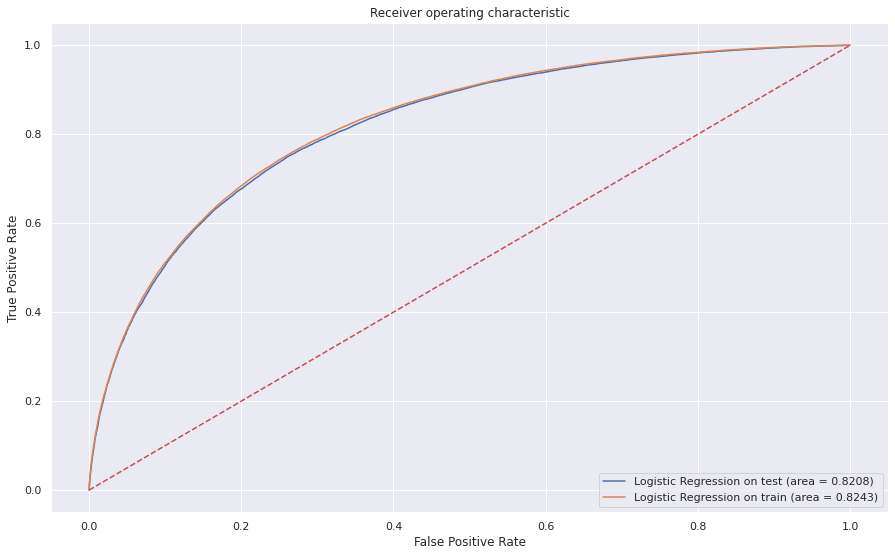

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt 
plt.rc("font", size=14)

logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

logit_roc_auc_train = roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, logreg.predict_proba(X_train)[:,1])

plt.figure(figsize=(15, 9))
plt.plot(fpr, tpr, label='Logistic Regression on test (area = %0.4f)' % logit_roc_auc)
plt.plot(fpr_train, tpr_train, label='Logistic Regression on train (area = %0.4f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42, C=best_c).fit(X_test, y_test)
pred = clf.predict_proba(X_test)

print('test Gini =', Gini(y_test, pred[:, 1]))
print('test AUC_ROC =', roc_auc_score(y_test.values, pred[:, 1]))

test Gini = 0.6430598946442625
test AUC_ROC = 0.8215299473221312


Получилось незначительно, но улучшить качество модели.

### На OneHot переменных

In [ ]:
numeric_features = ['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
                    'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'earliest_cr_year']

categorical = ['term', 'grade', 'home_ownership', 'purpose', 'addr_state', 'issue_month']  


column_transformer = ColumnTransformer([
    # ('CleanCesius', SimpleImputer(strategy="mean"), numeric_features),
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps = [
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])


with mlflow.start_run(run_name="Логистическая регрессия с кодированием"):

        x = data.drop(['risk'], axis=1)
        y = data['risk']

        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)

        model = pipeline.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        f1 = f1_score(y_test, y_pred_test, average='weighted')

        ras = roc_auc_score(y_test.values, y_pred_test)

        mlflow.log_metric(" F1 ", f1)

        mlflow.log_metric(" ROC-AUC ", ras)
        mlflow.log_param( " Average of F1", "weighted")

        mlflow.log_param( " Model name ", "LogisticRegression")

        mlflow.log_param( " Scaling type ", "StandardScaler")
        mlflow.log_param( " Encoding type ", "OneHotEncoder")

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model, "model", registered_model_name="LogisticRegression")
        else:
            mlflow.sklearn.log_model(model, "model")

# Ридж классифаер

In [ ]:
from sklearn.preprocessing import OrdinalEncoder # из-за того что LabelEncoding применяется только к таргету, используем другой кодировщик

In [ ]:
x = data.drop(['risk', 'loan_status'], axis=1)
y = data['risk']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)

In [ ]:
numeric_features = x.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical = x.select_dtypes(include=['object']).columns.tolist()

In [ ]:
numeric_features = ['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
                    'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'earliest_cr_year']

categorical = ['term', 'grade', 'home_ownership', 'purpose', 'addr_state', 'issue_month']  


column_transformer = ColumnTransformer([
    #('CleanCesius', SimpleImputer(strategy="mean"), numeric_features),
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps = [
    ('ohe_and_scaling', column_transformer),
    ('regression', RidgeClassifier())
])

x = data.drop(['risk'], axis=1)
y = data['risk']


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)

with mlflow.start_run(run_name="RidgeClassifier"):

    model = pipeline.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    f1 = f1_score(y_test, y_pred_test, average='weighted')
    mlflow.log_metric(" F1 ", f1)

    ras = roc_auc_score(y_test.values, y_pred_test)
    mlflow.log_metric(" ROC-AUC ", ras)

    mlflow.log_param( " Scaling type ", "StandardScaler")
    mlflow.log_param( " Encoding type ", "OneHotEncoder")
    mlflow.log_param( " Solver ", "lbfgs")

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name="LogisticRegression")
    else:
        mlflow.sklearn.log_model(model, "model")

# DecisionTreeClassifier

Для начала попробую все категориальные признаки закодировать с помощью **LabelEncoder** и посмотреть на небольшое дерево. LabelEncoder преобразует все категориальные признаки в числовые значения, что делает удобным работу с данными через деревья, но немного оторвано от здравого смысла, поскольку теперь моделью все категориальные признаки воспринимаются исключительно как диапазоны или с определенным приоритетом (например, 0 < 1 < 2), и это сложно интерпретировать обратно.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
labelencoder = LabelEncoder()
standart = StandardScaler()

categorical = ['term', 'grade', 'emp_length', 'home_ownership', 'issue_month', 
               'earliest_cr_line', 'purpose',
               'verification_status', 'addr_state']

numeric_features = ['loan_amnt', 'annual_inc', 'int_rate', 'funded_amnt', 
                    'installment', 'dti', 'open_acc', 'revol_util', 'total_acc']

x = data[['term', 'grade', 'emp_length', 'home_ownership', 'issue_month', 
          'earliest_cr_line', 'purpose',
          'verification_status', 'addr_state', 
          'loan_amnt', 'annual_inc', 'int_rate', 'funded_amnt', 
          'installment', 'dti', 'open_acc', 'revol_util', 'total_acc']]

y = data['risk']

for _ in categorical:
  x[_] = labelencoder.fit_transform(x[_])

# ct = ColumnTransformer([
#         ('somename', StandardScaler(), numeric_features)
#     ], remainder='passthrough')

# ct.fit_transform(x)

In [ ]:
with mlflow.start_run(run_name="DecisionTreeClassifier"):

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

    tree = DecisionTreeClassifier(max_depth = 10)
    tree.fit(X_train, y_train)

    y_pred_train = tree.predict(X_train)
    y_pred_test = tree.predict(X_test)

    f1 = f1_score(y_test, y_pred_test, average='weighted')
    mlflow.log_metric(" F1 ", f1)

    ras = roc_auc_score(y_test.values, y_pred_test)
    mlflow.log_metric(" ROC-AUC ", ras)

    # mlflow.log_param( " Scaling type ", "StandardScaler")
    mlflow.log_param( " Encoding type ", "LabelEncoder")
    mlflow.log_param( " Max_depth ", 10)
    # mlflow.log_param( " Criterion ", "gini")
    mlflow.log_param( " max_features ", 18)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name="LogisticRegression")
    else:
        mlflow.sklearn.log_model(model, "model")

Попробуем настроить параметры модели:

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
# Настройка параметров модели https://habr.com/ru/company/ods/blog/322534/

tree_params = {'max_depth': range(1,11), 'max_features': range(4, 19)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


KeyboardInterrupt: ignored

In [ ]:
tree_grid.best_params_

In [ ]:
tree_grid.best_score_

0.9176347087690984

In [ ]:
accuracy_score(y_test, tree_grid.predict(X_test))

0.9176705101988212

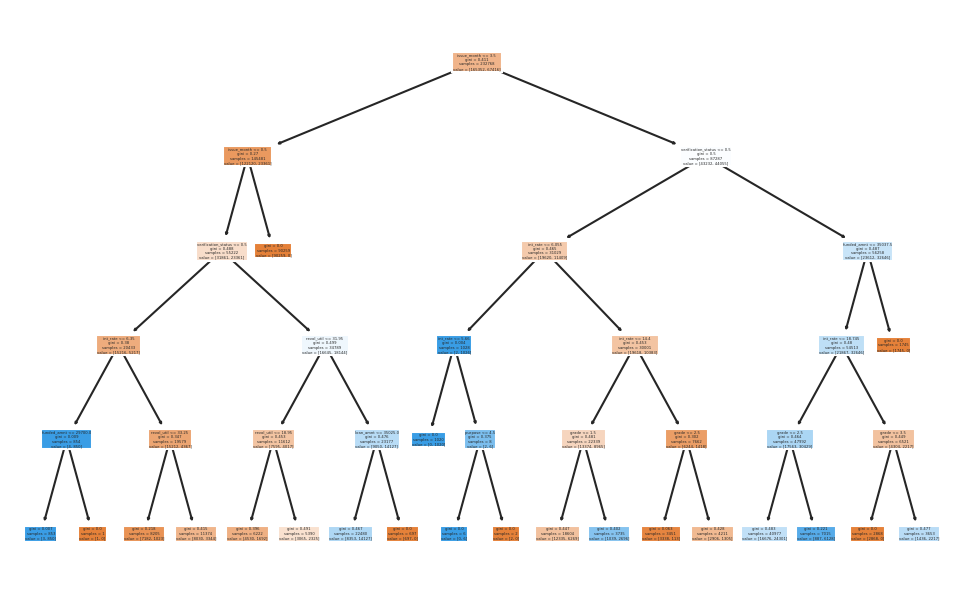

In [ ]:
plt.figure(figsize=(8, 5), dpi=150)
plot_tree(tree, feature_names = x.columns, filled=True)

plt.show()

Попробую еще другой, более наглядный вид визуализации:

In [1]:
 # !pip install dtreeviz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


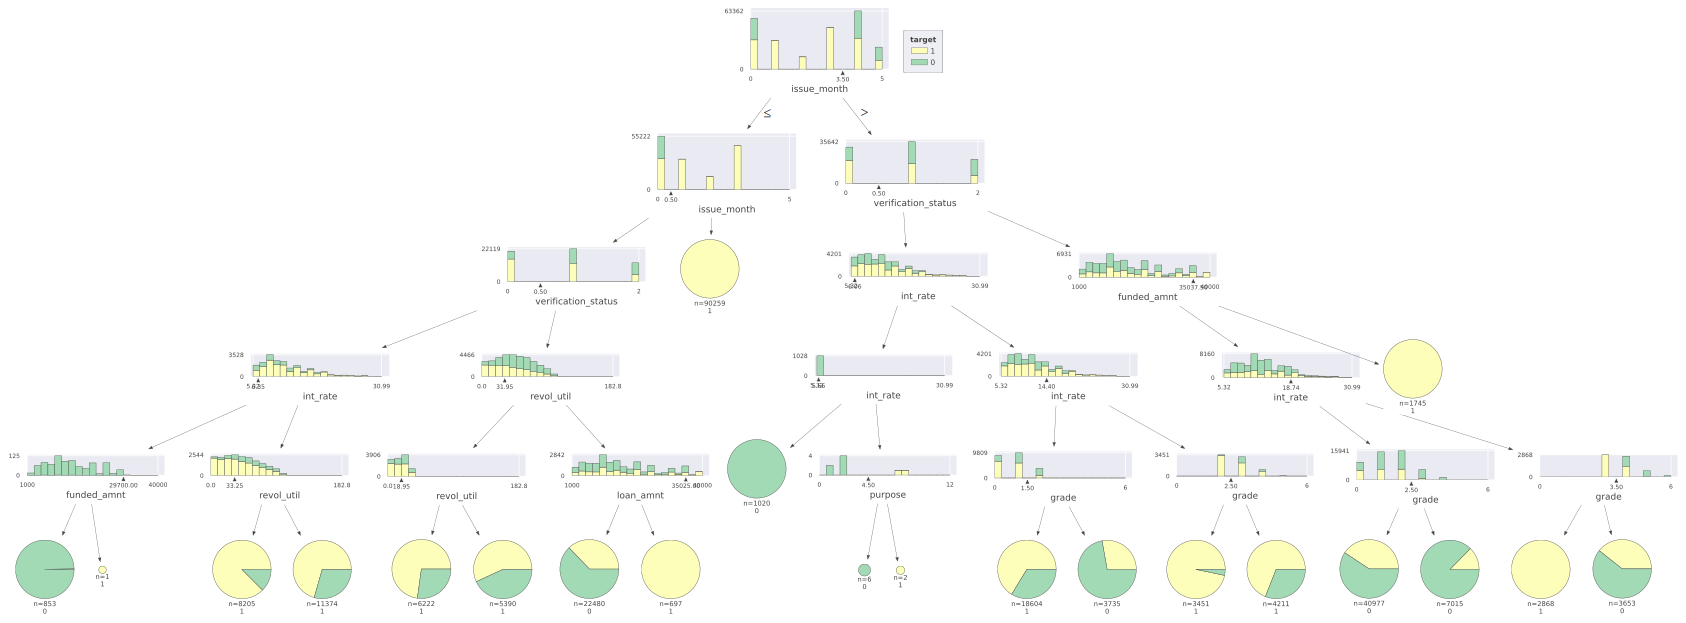

In [ ]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(tree, X_train, y_train,
                target_name = "target",
                feature_names = x.columns,
                class_names= ['1', '0'])

viz

In [ ]:
# print("Accuracy | train:", accuracy_score(y_train, tree.predict(X_train)))
# print("Accuracy | test:", accuracy_score(y_test, tree.predict(X_test)))

In [ ]:
y_train_score = tree.predict_proba(X_train)
y_test_score = tree.predict_proba(X_test)

Теперь попробую закодировать все категориальные с помощью **One Hot Encoding** и посмотреть на получшившиеся результаты. У данного вида кодирования есть плюсы: они более точно отражают изначальный "смысл" признаков, но и минусы - признаков становится очень много.

In [ ]:
onehotencoder = OneHotEncoder(handle_unknown='ignore')

x = data[['term', 'grade', 'emp_length', 'home_ownership', 'issue_month', 
          'earliest_cr_line', 'purpose',
          'verification_status', 'addr_state', 
          'loan_amnt', 'annual_inc', 'int_rate', 'funded_amnt', 
          'installment', 'dti', 'open_acc', 'revol_util', 'total_acc']]

y = data['risk']

x = onehotencoder.fit_transform(x)

In [ ]:
with mlflow.start_run(run_name="DecisionTreeClassifier"):

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

    tree = DecisionTreeClassifier(max_depth = 10)
    tree.fit(X_train, y_train)

    y_pred_train = tree.predict(X_train)
    y_pred_test = tree.predict(X_test)

    f1 = f1_score(y_test, y_pred_test, average='weighted')
    mlflow.log_metric(" F1 ", f1)

    ras = roc_auc_score(y_test.values, y_pred_test)
    mlflow.log_metric(" ROC-AUC ", ras)

    # mlflow.log_param( " Scaling type ", "StandardScaler")
    mlflow.log_param( " Encoding type ", "OneHotEncoder")
    mlflow.log_param( " Max_depth ", 10)
    # mlflow.log_param( " Criterion ", "gini")
    mlflow.log_param( " max_features ", 18)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name="LogisticRegression")
    else:
        mlflow.sklearn.log_model(model, "model")

По качеству получилось, что OneHot кодирование даже немного проигрывает LabelEncoder, но оба значения метрики мне кажутся хорошими. 

С точки зрения наглядности построения дерева, у меня получилось хорошо отразить разделение с помощью Label, но с OneHot это почти нереально, потому что признаков получается слишком много для какой-то визуальной демонстрации (либо я плохо искала)

# XGBoost

In [ ]:
# https://www.machinelearningmastery.ru/a-beginners-guide-to-xgboost-87f5d4c30ed7/

In [ ]:
# pip install xgboost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score

In [ ]:
x = data.drop(['risk', 'loan_status', 'issue_d'], axis=1)
y = data['risk']

# onehotencoder = OneHotEncoder()
# x = onehotencoder.fit_transform(x)

for _ in x.columns:
  x[_] = labelencoder.fit_transform(x[_])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

Код из моего дз7 по МО:

Best n_estimators:  9


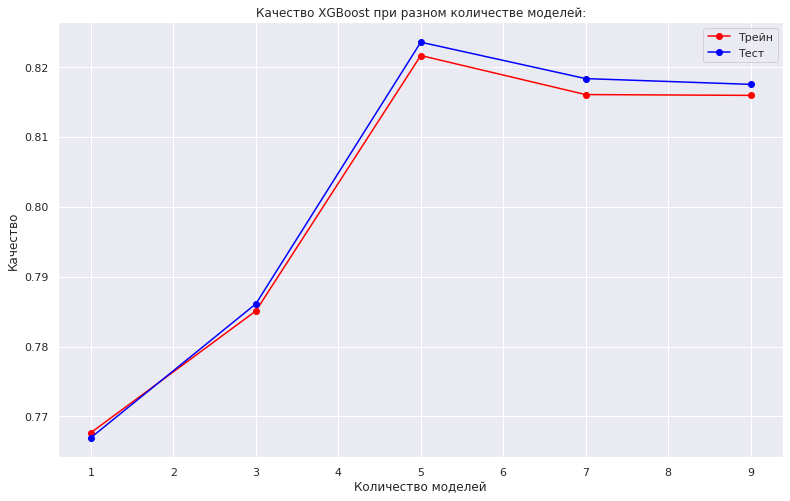

In [ ]:
results = {'train_score': [], 'test_score': []}
depths = range(1, 10, 2)

best_n_estimators = 0
scoren_estimators = 0


for i in depths:
        param = {
          'n_estimators': i,
          }

        clf = XGBClassifier(n_estimators=i)
        clf.fit(X_train, y_train)
        # print ('score ', clf.score(x_test, y_test))

        # Снова аналогично сохраняем решения
        results['train_score'].append(clf.score(X_train, y_train))
        results['test_score'].append(clf.score(X_test, y_test))

        if clf.score(X_test, y_test) > scoren_estimators:
          best_n_estimators = i


plt.figure(figsize=(13, 8))

plt.plot(depths, results['train_score'], label='Трейн', color='red', marker='o')
plt.plot(depths, results['test_score'], label='Тест', color='blue', marker='o')

print('Best n_estimators: ', best_n_estimators)

plt.title('Качество XGBoost при разном количестве моделей:')
plt.xlabel('Количество моделей')
plt.ylabel('Качество')
plt.legend()
plt.show()

Best learning_rate:  0.9


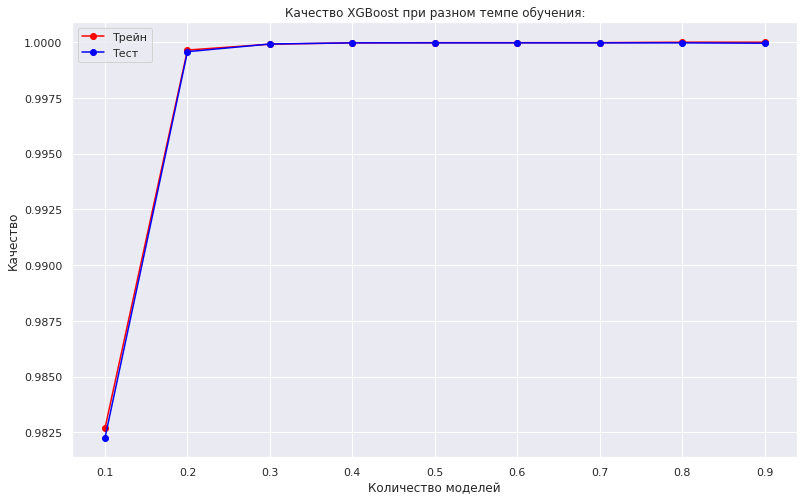

In [ ]:
results = {'train_score': [], 'test_score': []}
depths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_learning_rate = 0
score_learning_rate = 0


for i in range(9):
        param = {
          'learning_rate': depths[i],
          }

        clf = XGBClassifier(learning_rate=depths[i])
        clf.fit(X_train, y_train)
        # print ('score ', clf.score(x_test, y_test))

        # Снова аналогично сохраняем решения
        results['train_score'].append(clf.score(X_train, y_train))
        results['test_score'].append(clf.score(X_test, y_test))

        if clf.score(X_test, y_test) > score_learning_rate:
          best_learning_rate = depths[i]


plt.figure(figsize=(13, 8))

plt.plot(depths, results['train_score'], label='Трейн', color='red', marker='o')
plt.plot(depths, results['test_score'], label='Тест', color='blue', marker='o')


print('Best learning_rate: ', best_learning_rate)

plt.title('Качество XGBoost при разном темпе обучения:')
plt.xlabel('Количество моделей')
plt.ylabel('Качество')
plt.legend()
plt.show()

In [ ]:
from matplotlib import pyplot
from xgboost import plot_importance

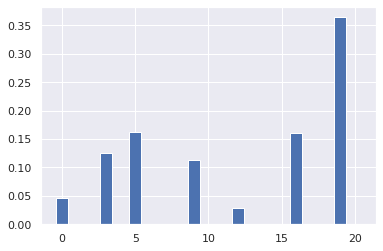

In [ ]:
with mlflow.start_run(run_name="XGBClassifier"):


  clf = XGBClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate)
  clf.fit(X_train, y_train)


  y_pred_test = clf.predict(X_test)

  ras = roc_auc_score(y_test.values, y_pred_test)
  mlflow.log_metric(" ROC-AUC ", ras)

  # mlflow.log_param( " Scaling type ", "StandardScaler")
  mlflow.log_param( " Encoding type ", "OneHotEncoder")
  mlflow.log_param( " Max_depth ", 10)
  # mlflow.log_param( " Criterion ", "gini")
  mlflow.log_param( " max_features ", 18)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(model, "model", registered_model_name="LogisticRegression")
  else:
      mlflow.sklearn.log_model(model, "model")

  pyplot.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
  pyplot.show()

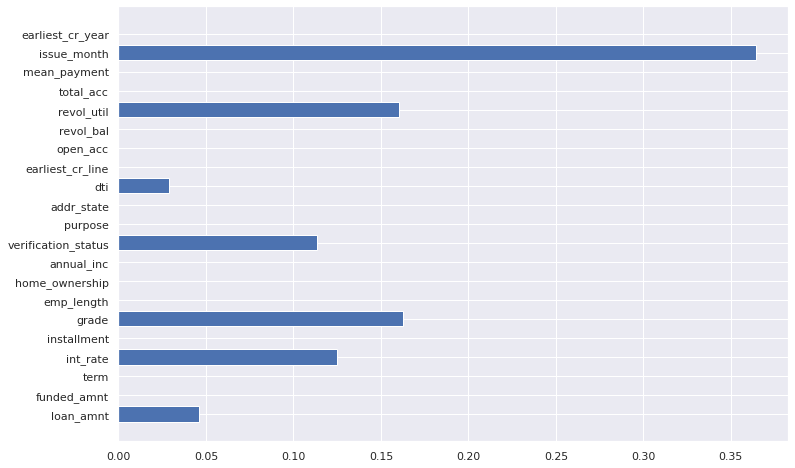

In [ ]:
# plot_importance(clf)
plt.figure(figsize=(12, 8))
plt.barh(x.columns, clf.feature_importances_)

plt.show()

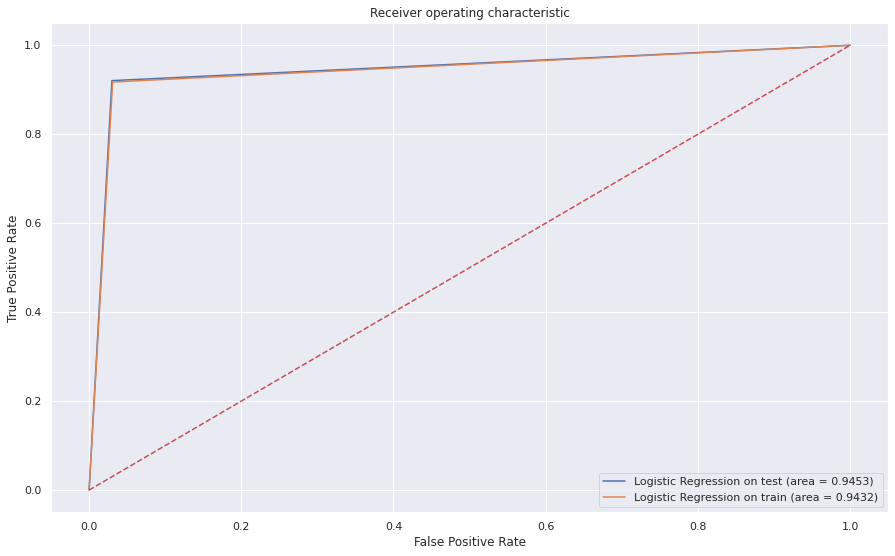

In [ ]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))

roc_auc_xgboost = roc_auc_score(y_train, clf.predict(X_train))
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, clf.predict(X_train))

plt.figure(figsize=(15, 9))
plt.plot(fpr, tpr, label='Logistic Regression on test (area = %0.4f)' % logit_roc_auc)
plt.plot(fpr_train, tpr_train, label='Logistic Regression on train (area = %0.4f)' % roc_auc_xgboost)
plt.plot([0, 1], [0, 1],'r--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# CatBoost

In [ ]:
# https://xn--80ajickj6abfedo.xn--p1ai/2019/04/29/catboost-%D0%BE%D1%82-%D1%8F%D0%BD%D0%B4%D0%B5%D0%BA%D1%81%D0%B0-%D1%80%D0%B0%D0%B7%D0%B1%D0%B8%D1%80%D0%B0%D0%B5%D0%BC%D1%81%D1%8F/

In [ ]:
# !pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
X = data.drop(['risk', 'loan_status', 'issue_d', 'id'], axis=1)
Y = data['risk']

In [ ]:
categorical = X.select_dtypes(include=['object']).columns.tolist()

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, train_size=0.7, random_state=1234)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6741076	test: 0.6743633	best: 0.6743633 (0)	total: 1s	remaining: 4m 59s
1:	learn: 0.6560819	test: 0.6565201	best: 0.6565201 (1)	total: 1.94s	remaining: 4m 48s
2:	learn: 0.6391787	test: 0.6397860	best: 0.6397860 (2)	total: 2.98s	remaining: 4m 54s
3:	learn: 0.6249215	test: 0.6256454	best: 0.6256454 (3)	total: 4.01s	remaining: 4m 56s
4:	learn: 0.6120521	test: 0.6128775	best: 0.6128775 (4)	total: 4.99s	remaining: 4m 54s
5:	learn: 0.5997056	test: 0.6006365	best: 0.6006365 (5)	total: 6.06s	remaining: 4m 56s
6:	learn: 0.5856074	test: 0.5865948	best: 0.5865948 (6)	total: 7.07s	remaining: 4m 56s
7:	learn: 0.5757134	test: 0.5767759	best: 0.5767759 (7)	total: 8.07s	remaining: 4m 54s
8:	learn: 0.5659004	test: 0.5670336	best: 0.5670336 (8)	total: 9.06s	remaining: 4m 52s
9:	learn: 0.5579173	test: 0.5591252	best: 0.5591252 (9)	total: 10.7s	remaining: 5m 11s
10:	learn: 0.5497583	test: 0.5510412	best: 0.5510412 (10)	total: 11.3s	remaining: 4m 57s
11:	learn: 0.5412068	test: 0.5424843	best: 0

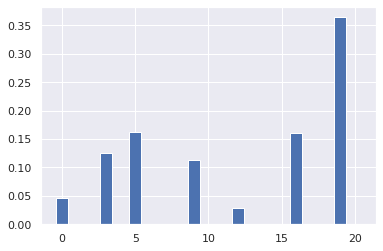

In [ ]:
best_model = CatBoostClassifier(
   iterations=300,
   learning_rate = 0.03,
   custom_loss=['AUC', 'Accuracy'],
   use_best_model=True,
   depth=6
)

with mlflow.start_run(run_name="CatBoostClassifier"):

  best_model.fit(
    X_train, y_train,
    cat_features=categorical,
    eval_set=(X_validation, y_validation),
    early_stopping_rounds=50,
    plot=True
  )

  preds_class = best_model.predict(X_validation)
  ras = roc_auc_score(y_validation.values, preds_class)

  mlflow.log_metric(" ROC-AUC ", ras)
  print(" ROC-AUC ", ras)

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(model, "model", registered_model_name="LogisticRegression")
  else:
      mlflow.sklearn.log_model(model, "model")

  pyplot.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
  pyplot.show()

# print('Resulting tree count:', best_model.tree_count_)

In [ ]:
preds_class = best_model.predict(X_validation)

print(best_model.get_best_score())

{'learn': {'Accuracy': 0.9602835966380373, 'Logloss': 0.12884149101053313}, 'validation': {'Accuracy': 0.9603913659185512, 'Logloss': 0.12952984449753155, 'AUC': 0.994166365503294}}


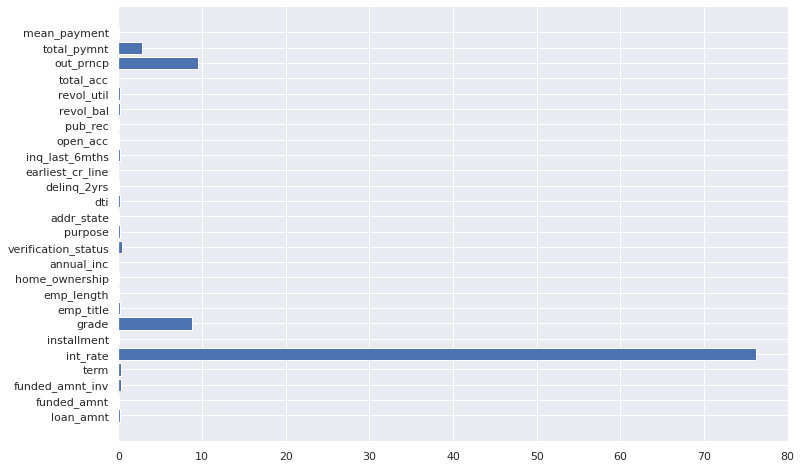

In [ ]:
# plot_importance(clf)
plt.figure(figsize=(12, 8))
plt.barh(X.columns, best_model.feature_importances_)

plt.show()

In [ ]:
roc_auc_catboost = roc_auc_score(y_validation.values, preds_class)

print("ROC-AUC", roc_auc_catboost)

ROC-AUC 0.9501188631508852


In [ ]:
# pip install shap

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

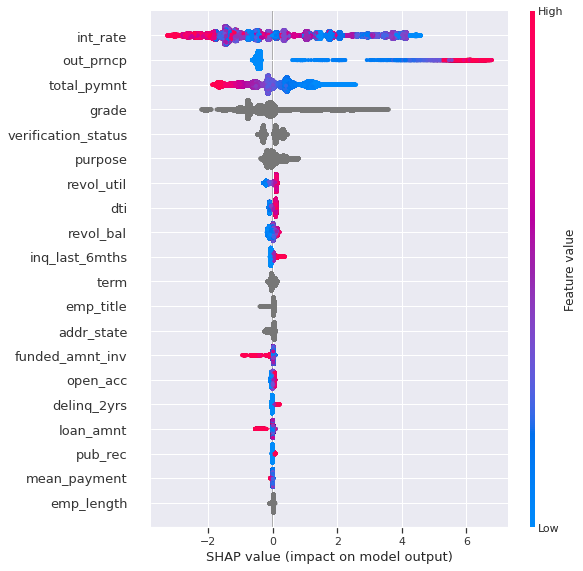

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


In [ ]:
from catboost import cv
from catboost import Pool

In [ ]:
params = best_model.get_params()

params['iterations'] = 10
params['custom_loss'] = 'AUC'
params['loss_function']= 'Logloss'

del params['use_best_model']

pool1 = Pool(X, label=Y, cat_features=categorical)

In [ ]:
cv_data = cv(
   params = params,
   pool = pool1,
   fold_count=2,
   inverted=False,
   shuffle=True,
   stratified=False,
   partition_random_seed=0
)

Training on fold [0/2]
0:	learn: 0.6744959	test: 0.6745560	best: 0.6745560 (0)	total: 226ms	remaining: 2.03s
1:	learn: 0.6569253	test: 0.6570540	best: 0.6570540 (1)	total: 404ms	remaining: 1.61s
2:	learn: 0.6419475	test: 0.6421462	best: 0.6421462 (2)	total: 589ms	remaining: 1.38s
3:	learn: 0.6271231	test: 0.6273654	best: 0.6273654 (3)	total: 821ms	remaining: 1.23s
4:	learn: 0.6137068	test: 0.6139877	best: 0.6139877 (4)	total: 1.03s	remaining: 1.03s
5:	learn: 0.6019982	test: 0.6023147	best: 0.6023147 (5)	total: 1.32s	remaining: 884ms
6:	learn: 0.5903060	test: 0.5906644	best: 0.5906644 (6)	total: 1.61s	remaining: 690ms
7:	learn: 0.5800368	test: 0.5803707	best: 0.5803707 (7)	total: 1.94s	remaining: 486ms
8:	learn: 0.5710897	test: 0.5714618	best: 0.5714618 (8)	total: 2.29s	remaining: 255ms
9:	learn: 0.5595649	test: 0.5599600	best: 0.5599600 (9)	total: 2.6s	remaining: 0us

bestTest = 0.5599599816
bestIteration = 9

Training on fold [1/2]
0:	learn: 0.6746330	test: 0.6745875	best: 0.6745875 (

In [ ]:
cv_data

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0           0.674572          0.000022            0.674564   
1           1           0.656868          0.000263            0.656845   
2           2           0.641080          0.001507            0.641025   
3           3           0.626660          0.000998            0.626582   
4           4           0.613273          0.001011            0.613190   
5           5           0.601635          0.000961            0.601549   
6           6           0.590002          0.000937            0.589911   
7           7           0.579198          0.001658            0.579105   
8           8           0.570344          0.001582            0.570243   
9           9           0.558867          0.001546            0.558766   

   train-Logloss-std  test-AUC-mean  test-AUC-std  
0           0.000097       0.811384      0.001515  
1           0.000113       0.828721      0.003255  
2           0.001305       0.829443      0.006311  
3           0.000765       0.835046      0.005286  
4           0.000731       0.835564      0.004001  
5           0.000635       0.835419      0.004256  
6           0.000559       0.836405      0.003466  
7           0.001317       0.838692      0.003260  
8           0.001197       0.838551      0.003587  
9           0.001130       0.846896      0.002894

In [ ]:
best_value = np.max(cv_data['test-AUC-mean'])
best_iter = np.argmax(cv_data['test-AUC-mean'])

print('Best validation AUC score: {:.2f}±{:.2f} on step {}'.format(
   best_value,
   cv_data['test-AUC-std'][best_iter],
   best_iter
))

Best validation AUC score: 0.85±0.00 on step 9
